<a href="https://colab.research.google.com/github/hssathu4596/XAI_Medical_Imaging/blob/main/XAI_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI for Medical Images

## Loading Data

In [1]:
! pip install -q kaggle

In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [5]:
! kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 94% 149M/158M [00:01<00:00, 125MB/s]
100% 158M/158M [00:01<00:00, 97.1MB/s]


In [6]:
import os
import zipfile

# Define the zip file path and extraction directory
zip_file_path = 'covid19-image-dataset.zip'
extraction_dir = 'covid19-image-dataset'

# Check if the zip file exists
if os.path.exists(zip_file_path):
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extraction_dir)
    print(f"Extracted all contents to '{extraction_dir}'")
else:
    print(f"File '{zip_file_path}' does not exist.")

Extracted all contents to 'covid19-image-dataset'


In [7]:
base_dir = '/content/covid19-image-dataset/Covid19-dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

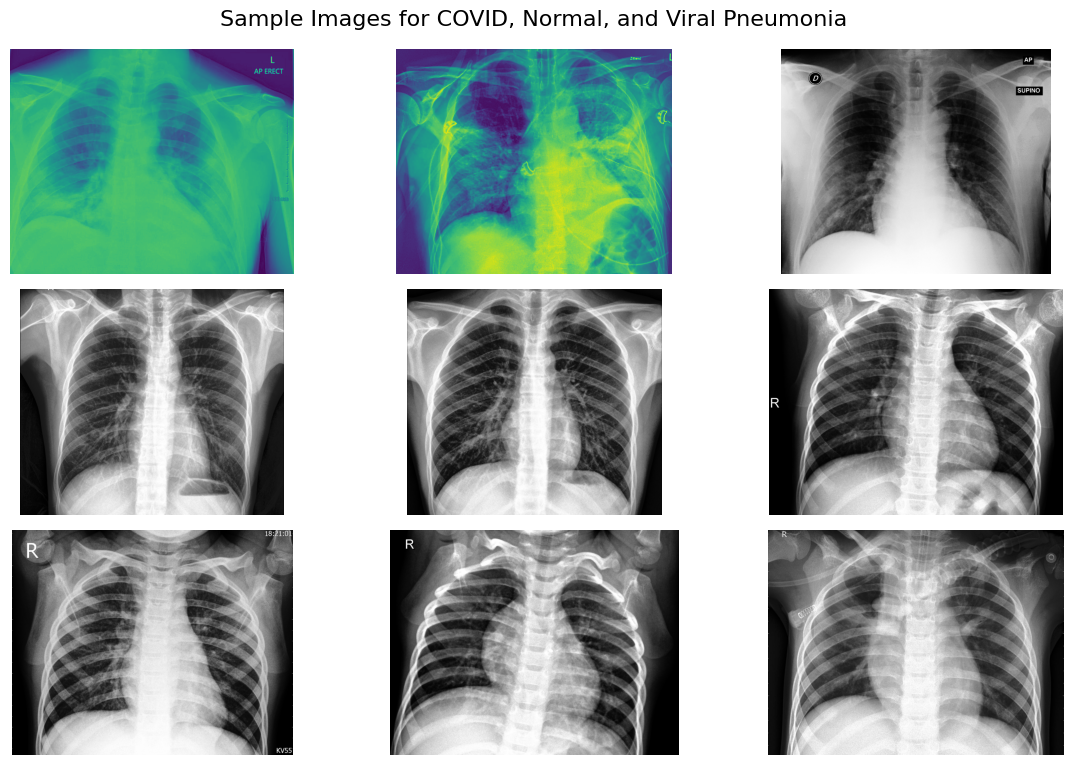

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

num_images_per_class = 3

classes = ['Covid', 'Normal', 'Viral Pneumonia']

fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(12, 8))

# Set a consistent size for all subplots
for ax in axes.flatten():
    ax.set_aspect('equal')

for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_per_class]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        img = mpimg.imread(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_ylabel(class_name, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Sample Images for COVID, Normal, and Viral Pneumonia', fontsize=16)
plt.show()

## Data Pre-processing

As we can see, the images are not currently the same size or color. Thus, we make use of data preprocessing to ensure the model's results aren't influenced by these factors, instead focusing on the actual content of the scans. For this, we use the cv2 Python package to resize the images so that they're uniform and if an image is in color, convert it from RGB to

In [14]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [15]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is grayscale, if so convert to RGB
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Resize the image
    image = cv2.resize(image, target_size)

    # Normalize the image
    image = image / 255.0

    return image

In [25]:
def load_dataset(directory, target_size=(224, 224)):
    images = []
    labels = []
    classes = ['Covid', 'Normal', 'Viral Pneumonia']

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = preprocess_image(image_path, target_size)
            images.append(image)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))

    return images, labels

In [26]:
train_images, train_labels = load_dataset(train_dir, target_size=(224, 224))
test_images, test_labels = load_dataset(test_dir, target_size=(224, 224))

In [35]:
## Augments the training data, because right now we don't have that many in the training set

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

In [34]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

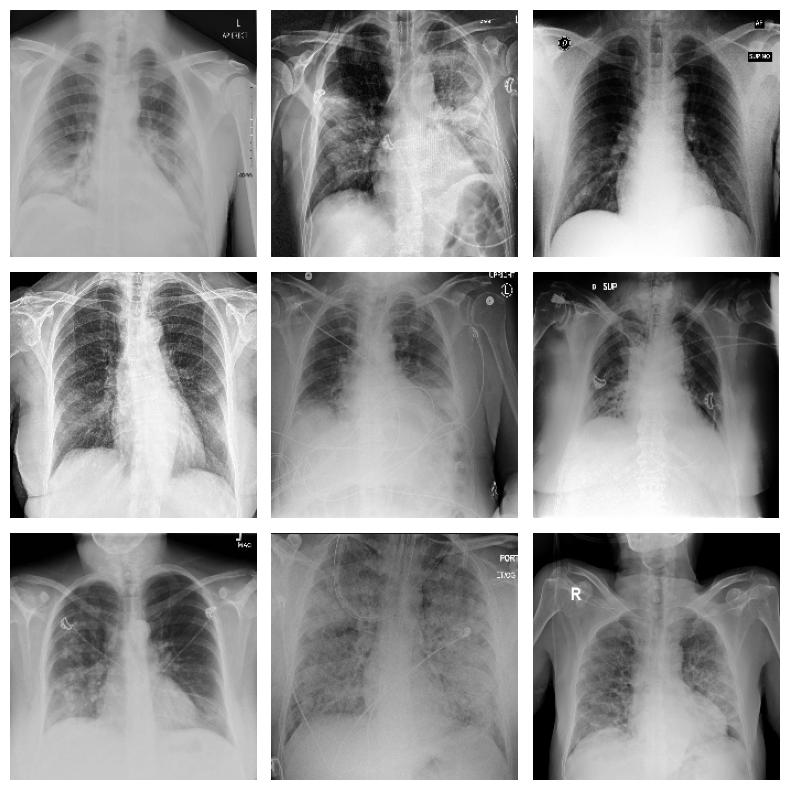

In [30]:
# Visualization of images that were just created

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()


## Model Evaluation

For this, we are using a simple 2D Convolutional Neural Network for classification of whether the scan indicates viral pneumonia, COVID, or a normal diagnosis.


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [32]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: COVID, normal, viral pneumonia
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/20
8/8 [==============================] - 25s 3s/step - loss: 0.4783 - accuracy: 0.7849 - val_loss: 0.4413 - val_accuracy: 0.8182
Epoch 2/20
8/8 [==============================] - 24s 3s/step - loss: 0.3964 - accuracy: 0.8446 - val_loss: 0.4297 - val_accuracy: 0.8182
Epoch 3/20
8/8 [==============================] - 26s 3s/step - loss: 0.4975 - accuracy: 0.7849 - val_loss: 0.4054 - val_accuracy: 0.8030
Epoch 4/20
8/8 [==============================] - 25s 3s/step - loss: 0.4598 - accuracy: 0.8048 - val_loss: 0.4364 - val_accuracy: 0.8182
Epoch 5/20
8/8 [==============================] - 24s 3s/step - loss: 0.4271 - accuracy: 0.8446 - val_loss: 0.4809 - val_accuracy: 0.7576
Epoch 6/20
8/8 [==============================] - 25s 3s/step - loss: 0.4574 - accuracy: 0.8167 - val_loss: 0.4152 - val_accuracy: 0.8182
Epoch 7/20
8/8 [==============================] - 25s 3s/step - loss: 0.3944 - accuracy: 0.8406 - val_loss: 0.4391 - val_accuracy: 0.7576
Epoch 8/20
8/8 [==================

In [40]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

3/3 [==============================] - 2s 583ms/step - loss: 0.3690 - accuracy: 0.8333
Test Accuracy: 0.8333333134651184


## Incorporation of Grad-CAM for Explainability

In [41]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model

1/1 [==============================] - 0s 69ms/step
Predicted Label: COVID
Actual Label: COVID


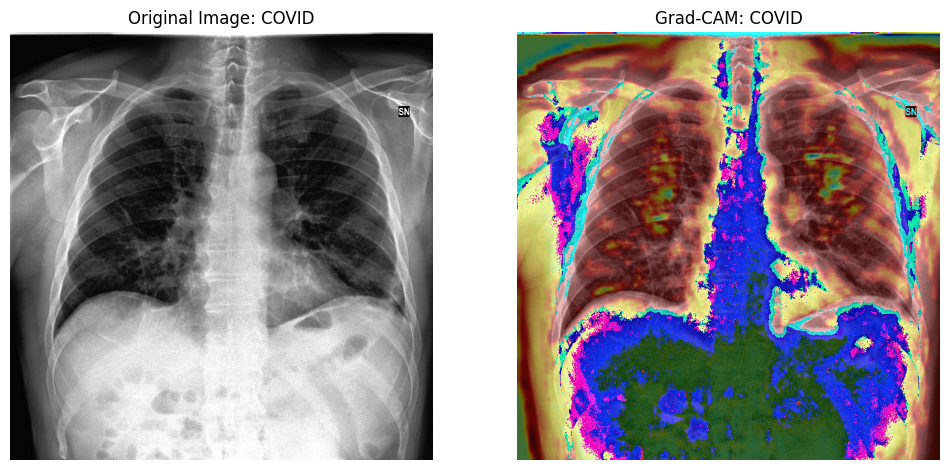

1/1 [==============================] - 0s 180ms/step
Predicted Label: normal
Actual Label: Normal


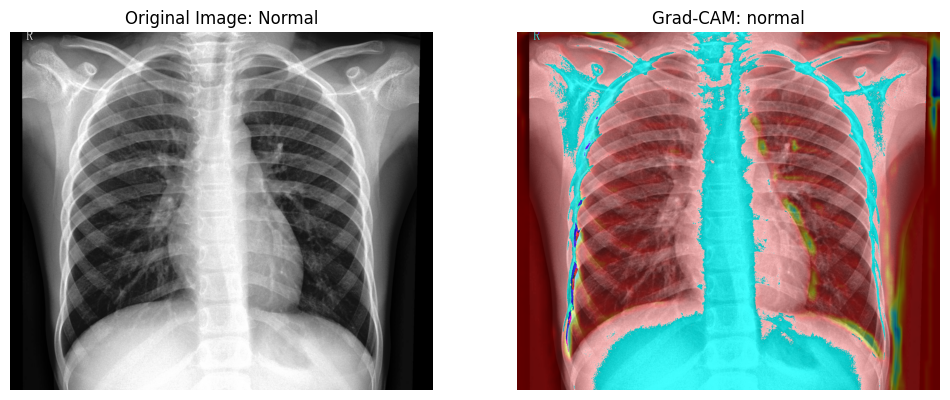

1/1 [==============================] - 0s 129ms/step
Predicted Label: viral pneumonia
Actual Label: Viral Pneumonia


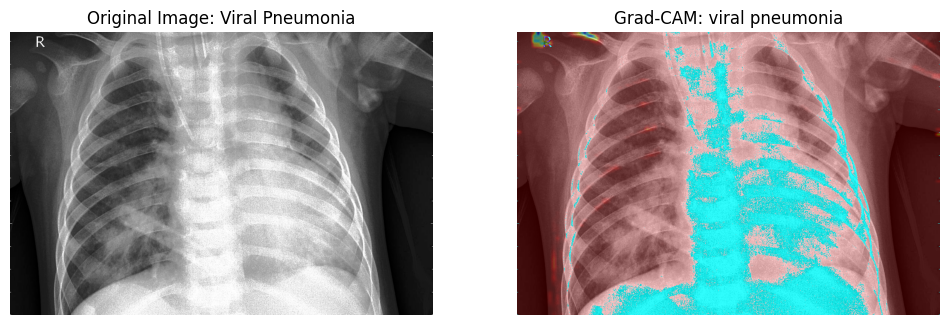

In [58]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + image
    return superimposed_img

def predict_and_explain(img_path, model, last_conv_layer_name):
    img_array = preprocess_image(img_path)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    class_names = ['COVID', 'normal', 'viral pneumonia']
    predicted_label = class_names[predicted_class]

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=predicted_class)
    superimposed_img = superimpose_heatmap(img_path, heatmap)

    return predicted_label, superimposed_img, heatmap

def display_images(original_img, superimposed_img, predicted_label, actual_label):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(f'Original Image: {actual_label}')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Grad-CAM: {predicted_label}')
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')

    plt.show()

# Example Images
image_paths = [
    ('/content/covid19-image-dataset/Covid19-dataset/test/Covid/0100.jpeg', 'COVID'),
    ('/content/covid19-image-dataset/Covid19-dataset/test/Normal/0120.jpeg', 'Normal'),
    ('/content/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia/0110.jpeg', 'Viral Pneumonia')
]

last_conv_layer_name = 'conv2d_1'

for img_path, actual_label in image_paths:
    predicted_label, superimposed_img, heatmap = predict_and_explain(img_path, model, last_conv_layer_name)

    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}")

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    display_images(original_img, superimposed_img, predicted_label, actual_label)
